In [2]:
from mewpy.io import Reader, Engines, read_model, read_json
from mewpy.germ.analysis import get_real_initial_state, ifva, SRFBA, FBA
import pandas as pd
import os
import re

In [3]:
models_dir = "..\\data\\tissue_models"

In [4]:
trn_fname = "..\\data\\pypath\\grouped_sirt1_trn_manually_curated.csv"
trn_reader = Reader(Engines.BooleanRegulatoryCSV,
                        trn_fname, sep=',', id_col=0, rule_col=1, header=0)

In [79]:
generic_sbml_fname = "..\\data\\models\\sirt1_recon3d\\Recon3D_SIRT1_generic_gpr_fix.xml"
generic_recon_reader = Reader(Engines.MetabolicSBML, generic_sbml_fname)
generic_model = read_model(generic_recon_reader, trn_reader)

In [86]:
reactions = list(generic_model.reactions.keys())

In [108]:
reactions = []
for reaction in generic_model.reactions.keys():
    model_reaction = generic_model.get(reaction)
    if not "target" in model_reaction.types:
        reactions.append(reaction)

In [5]:
results_regulatory = {}
for sbml_fname in os.listdir(models_dir):
    tissue = sbml_fname.split(".")[0].split("Recon3D_")[-1].split("_")[-1]
    try:
        _ = results_regulatory[tissue]
    except KeyError:
        results_regulatory[tissue] = {}
    print("tissue =",tissue)
    sbml_fname = models_dir+"\\"+sbml_fname
    print("sbml_fname =", sbml_fname)
    recon_reader = Reader(Engines.MetabolicSBML, sbml_fname)
    model = read_model(recon_reader, trn_reader)
    print("#Reactions =",len(model.reactions))
    print("Building srFBA model...", end ="")
    srfba_model = SRFBA(model).build()
    print("OK!")
    
    for sirt1_expression in [0.0, 0.25, 0.5, 0.75, 1.0]:
        print("sirt1_expression =", sirt1_expression)
        real_initial_state = get_real_initial_state(model, initial_state={"SIRT1": sirt1_expression}, strategy="mean")
        sol = srfba_model.optimize(initial_state = real_initial_state)
        print("Solution regulatory =",sol.objective_value)
        results_regulatory[tissue][sirt1_expression] = sol.to_series()

tissue = Adipose - Subcutaneous
sbml_fname = ..\data\tissue_models\Recon3D_Adipose - Subcutaneous.xml
#Reactions = 5932
Building srFBA model...OK!
sirt1_expression = 0.0
Solution regulatory = 6.387933740700994
sirt1_expression = 0.25
Solution regulatory = 6.387933740700994
sirt1_expression = 0.5
Solution regulatory = 6.387933740700994
sirt1_expression = 0.75
Solution regulatory = 6.387933740700994
sirt1_expression = 1.0
Solution regulatory = 6.387933740700994
tissue = Adipose - Visceral (Omentum)
sbml_fname = ..\data\tissue_models\Recon3D_Adipose - Visceral (Omentum).xml
#Reactions = 5942
Building srFBA model...OK!
sirt1_expression = 0.0
Solution regulatory = 6.387933740700994
sirt1_expression = 0.25
Solution regulatory = 6.387933740700992
sirt1_expression = 0.5
Solution regulatory = 6.387933740700994
sirt1_expression = 0.75
Solution regulatory = 6.387933740700994
sirt1_expression = 1.0
Solution regulatory = 6.387933740700994
tissue = Adrenal Gland
sbml_fname = ..\data\tissue_models\Re

In [81]:
results_regulatory['Artery - Aorta'][0.0]

10FTHF7GLUtl      0.000000
10FTHF7GLUtm      0.000000
10FTHFtl          0.000000
10FTHFtm       -998.029679
13DAMPPOX         0.000000
                   ...    
PPA1              0.000000
GALNT14           1.000000
FOXO1             0.000000
PGAM1             1.000000
SIRT1             0.000000
Length: 7549, dtype: float64

In [109]:
import pandas as pd

records = []
for tissue, sirt1_dict in results_regulatory.items():
    for sirt1_value, flux_series in sirt1_dict.items():
        for reaction_id, flux_value in flux_series.items():
            if reaction_id in reactions:
                try:
                    flux_value = float(flux_value)  # Ensure it's a float
                except:
                    flux_value = 0.0  # Fallback if needed
                records.append({
                    'Tissue': tissue,
                    'SIRT1': float(sirt1_value),
                    'Reaction': str(reaction_id),
                    'Flux': flux_value
                })

df_long = pd.DataFrame(records)
df_long['Sample'] = df_long['Tissue'] + '_SIRT1_' + df_long['SIRT1'].astype(str)

In [110]:
df_long[-50:]

,Tissue,SIRT1,Reaction,Flux,Sample
1701835,Whole Blood,1.0,ATPS4mi,59.704802,Whole Blood_SIRT1_1.0
1701836,Whole Blood,1.0,CYOR_u10mi,0.734708,Whole Blood_SIRT1_1.0
1701837,Whole Blood,1.0,Htmi,0.000000,Whole Blood_SIRT1_1.0
1701838,Whole Blood,1.0,CYOOm3i,58.970094,Whole Blood_SIRT1_1.0
1701839,Whole Blood,1.0,ACITLn,0.000000,Whole Blood_SIRT1_1.0
1701840,Whole Blood,1.0,OAAtn,0.000000,Whole Blood_SIRT1_1.0
1701841,Whole Blood,1.0,CITtn,0.000000,Whole Blood_SIRT1_1.0
1701842,Whole Blood,1.0,DM_adprbp[n],0.000000,Whole Blood_SIRT1_1.0
1701843,Whole Blood,1.0,R_SIRT1,0.000000,Whole Blood_SIRT1_1.0
1701844,Whole Blood,1.0,LYSACn,0.000000,Whole Blood_SIRT1_1.0


In [112]:
# Pivot: rows = samples, columns = reactions
df_wide = df_long.pivot(index='Sample', columns='Reaction', values='Flux').fillna(0)

# Also extract Tissue and SIRT1 info again (in case we need them later)
df_wide.index = df_wide.index.astype(str)
df_wide['Tissue'] = df_wide.index.to_series().str.extract(r'^(.*?)_SIRT1_')
df_wide['SIRT1'] = df_wide.index.to_series().str.extract(r'_SIRT1_([0-9.]+)$')[0].astype(float)


In [113]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Drop metadata columns before scaling
flux_matrix = df_wide.drop(columns=['Tissue', 'SIRT1'])
flux_matrix_clean = flux_matrix.dropna(axis=1)  # optional if you want to drop reactions with NaNs

# Standardize
scaler = StandardScaler()
flux_matrix_scaled = scaler.fit_transform(flux_matrix_clean)

# PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(flux_matrix_scaled)

# Combine with metadata
pca_df = pd.DataFrame(reduced, columns=['PC1', 'PC2'], index=df_wide.index)
pca_df['SIRT1'] = df_wide['SIRT1'].values
pca_df['Tissue'] = df_wide['Tissue'].values


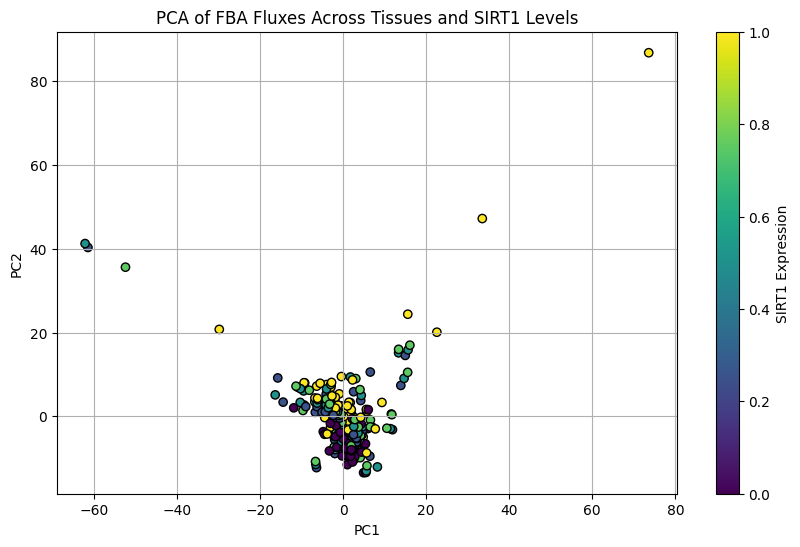

In [114]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    pca_df['PC1'], pca_df['PC2'],
    c=pca_df['SIRT1'],
    cmap='viridis',
    edgecolor='k'
)
plt.colorbar(scatter, label='SIRT1 Expression')
plt.title('PCA of FBA Fluxes Across Tissues and SIRT1 Levels')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()


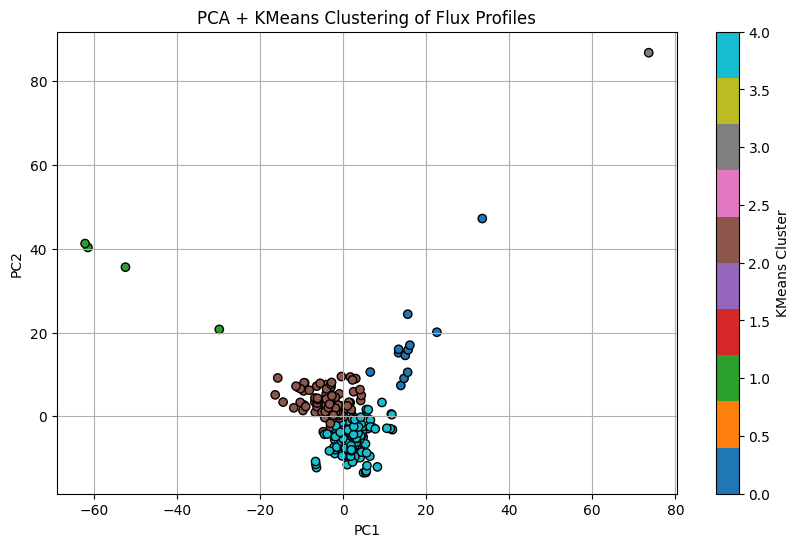

In [115]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
pca_df['Cluster'] = kmeans.fit_predict(reduced)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    pca_df['PC1'], pca_df['PC2'],
    c=pca_df['Cluster'],
    cmap='tab10',
    edgecolor='k'
)
plt.colorbar(scatter, label='KMeans Cluster')
plt.title('PCA + KMeans Clustering of Flux Profiles')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()


In [117]:
# Get top reactions contributing to PC1 and PC2
loadings = pd.DataFrame(pca.components_.T, index=flux_matrix_clean.columns, columns=['PC1', 'PC2'])

top_pc1 = loadings['PC1'].abs().sort_values(ascending=False).head(10)
top_pc2 = loadings['PC2'].abs().sort_values(ascending=False).head(10)

print("Top PC1 reactions:")
print(top_pc1)

print("\nTop PC2 reactions:")
print(top_pc2)


Top PC1 reactions:
Reaction
r1751          0.066579
r0729          0.066289
ACACT4p        0.066289
r0727          0.066289
HMR_3076       0.066023
HMR_3075       0.066023
HMR_3074       0.066023
ACACT8p        0.066023
FAOXC14C12x    0.065506
FAOXC16C14x    0.065302
Name: PC1, dtype: float64

Top PC2 reactions:
Reaction
CMPACNAtg    0.063142
UGALNACtg    0.062461
PAPtg        0.061891
PAPStg       0.061891
S23T4g       0.061891
AG13T18g     0.061891
CORE4GTg     0.061891
CORE3GTg     0.061891
AG13T17g     0.061891
AG13T16g     0.061891
Name: PC2, dtype: float64


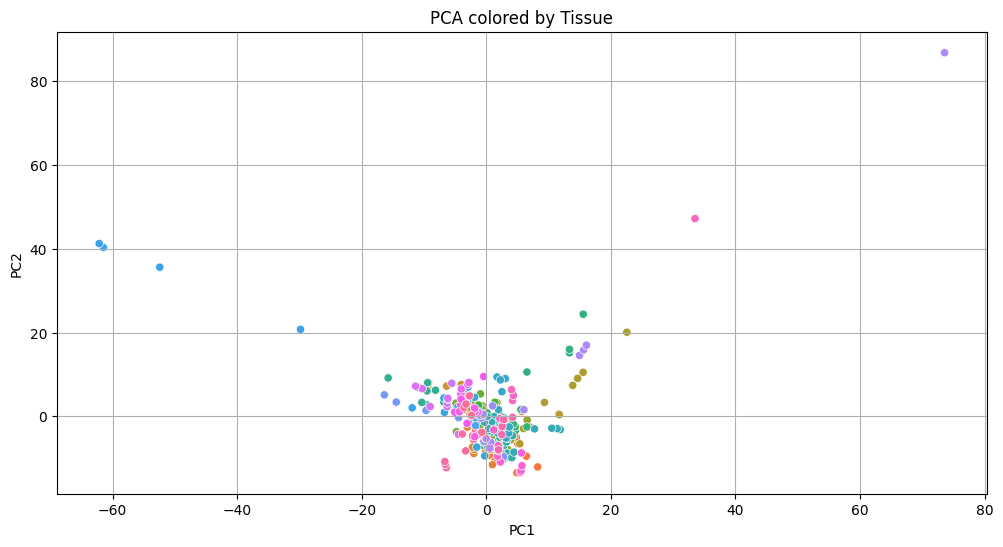

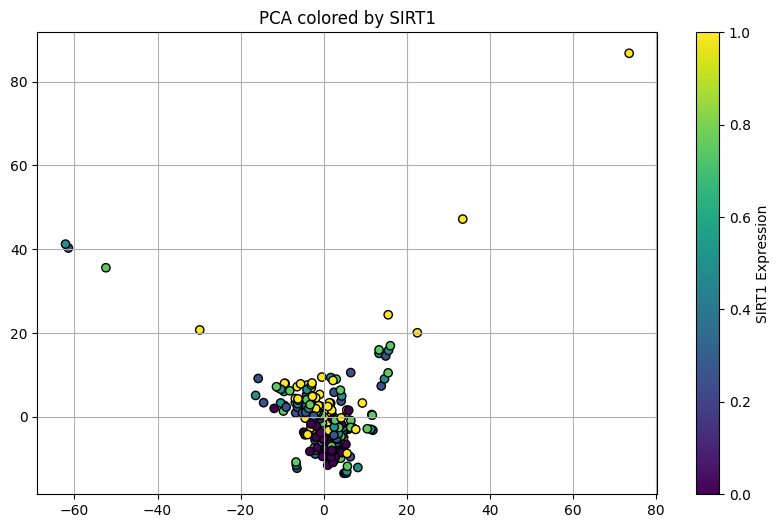

In [118]:
# By tissue (many categories, legend off)
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Tissue', data=pca_df, legend=False)
plt.title("PCA colored by Tissue")
plt.grid(True)
plt.show()

# Or SIRT1 again
plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['SIRT1'], cmap='viridis', edgecolor='k')
plt.colorbar(label='SIRT1 Expression')
plt.title('PCA colored by SIRT1')
plt.grid(True)
plt.show()


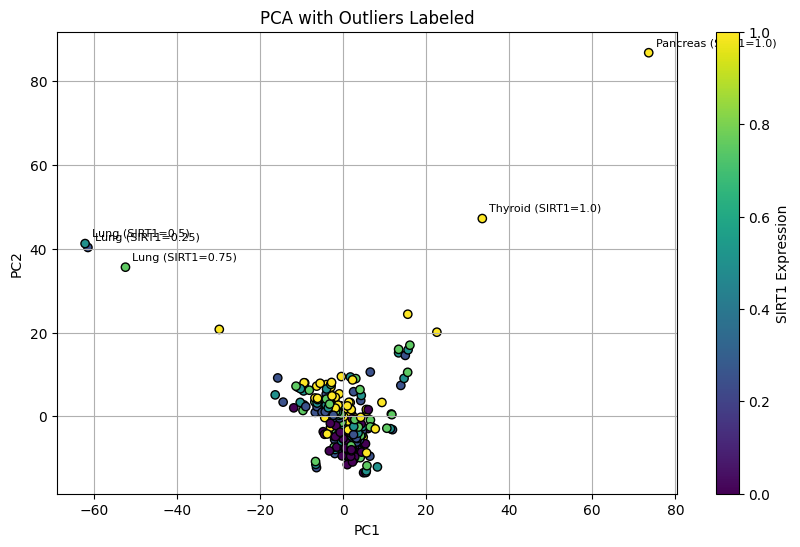

In [120]:
# Add Euclidean distance from origin to identify outliers
pca_df['Distance'] = (pca_df['PC1']**2 + pca_df['PC2']**2)**0.5
top_outliers = pca_df.sort_values(by='Distance', ascending=False).head(5)

# Annotate the top 5 on a PCA plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    pca_df['PC1'], pca_df['PC2'],
    c=pca_df['SIRT1'], cmap='viridis', edgecolor='k'
)
plt.colorbar(scatter, label='SIRT1 Expression')
plt.title('PCA with Outliers Labeled')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)

# Label the top outliers
for i, row in top_outliers.iterrows():
    plt.annotate(f"{row['Tissue']} (SIRT1={row['SIRT1']})", (row['PC1'], row['PC2']),
                 textcoords="offset points", xytext=(5,5), ha='left', fontsize=8)

plt.show()


In [122]:
for reaction in top_pc1.index:
    fluxes = flux_matrix_clean[reaction]
    corr = fluxes.corr(df_wide['SIRT1'])
    print(f"{reaction}: corr(SIRT1) = {corr:.2f}")


r1751: corr(SIRT1) = 0.04
r0729: corr(SIRT1) = -0.01
ACACT4p: corr(SIRT1) = -0.01
r0727: corr(SIRT1) = -0.01
HMR_3076: corr(SIRT1) = 0.07
HMR_3075: corr(SIRT1) = 0.07
HMR_3074: corr(SIRT1) = 0.07
ACACT8p: corr(SIRT1) = 0.07
FAOXC14C12x: corr(SIRT1) = -0.01
FAOXC16C14x: corr(SIRT1) = -0.01


C:\Users\Jordi\miniconda3\envs\cobrapy\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


_Pickler
end _Pickler
save
end


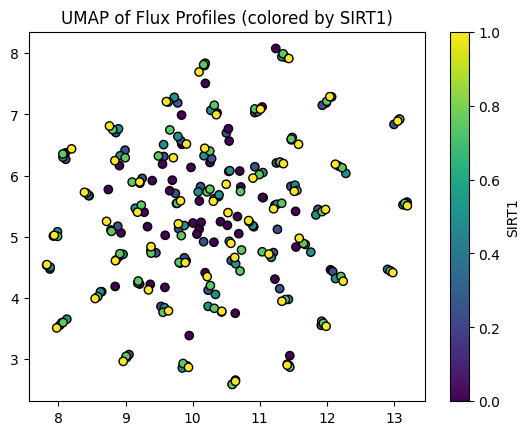

In [123]:
from umap import UMAP

umap_result = UMAP(n_neighbors=15, min_dist=0.1, random_state=42).fit_transform(flux_matrix_scaled)
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=df_wide['SIRT1'], cmap='viridis', edgecolor='k')
plt.title("UMAP of Flux Profiles (colored by SIRT1)")
plt.colorbar(label='SIRT1')
plt.show()


C:\Users\Jordi\AppData\Local\Temp\ipykernel_28348\2730388858.py:10: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


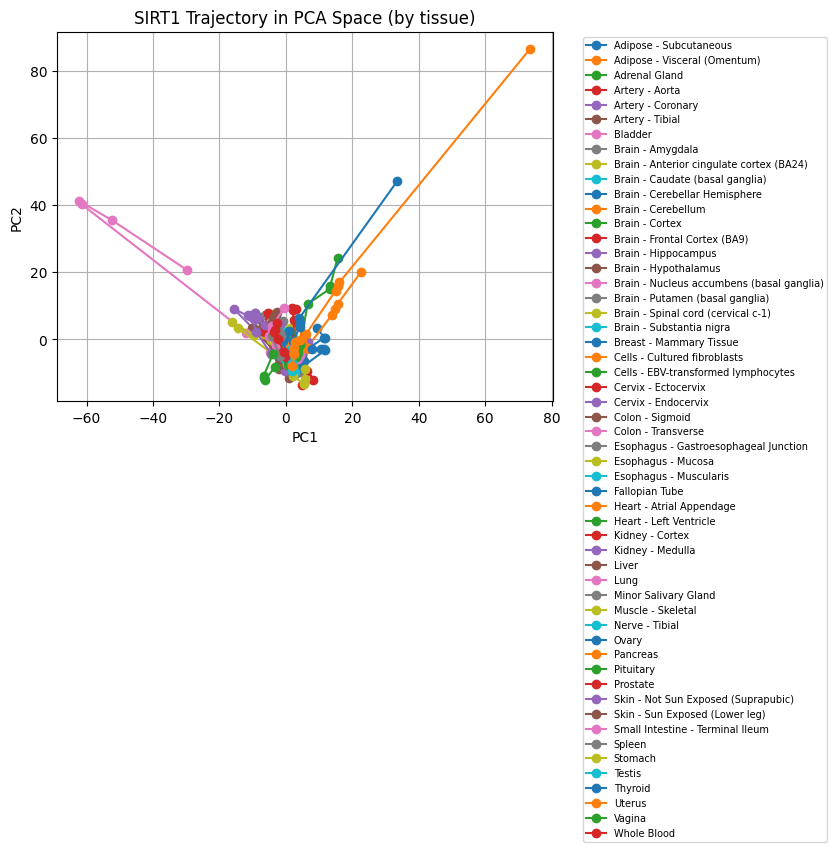

In [124]:
for tissue in pca_df['Tissue'].unique():
    subset = pca_df[pca_df['Tissue'] == tissue].sort_values(by='SIRT1')
    plt.plot(subset['PC1'], subset['PC2'], marker='o', label=tissue)

plt.title("SIRT1 Trajectory in PCA Space (by tissue)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7)
plt.tight_layout()
plt.show()


In [125]:
variation = (
    df_long
    .groupby(['Tissue', 'Reaction'])['Flux']
    .agg(lambda x: x.max() - x.min())
    .reset_index()
)

most_sirt1_responsive = variation.sort_values(by='Flux', ascending=False).head(10)
print(most_sirt1_responsive)


                                       Tissue  Reaction    Flux
263118                               Pancreas     r1147  2000.0
3287                   Adipose - Subcutaneous     KCC2t  2000.0
157887                        Colon - Sigmoid   DALAt2r  2000.0
280858    Skin - Not Sun Exposed (Suprapubic)    NAt3_1  2000.0
283261    Skin - Not Sun Exposed (Suprapubic)     r2200  2000.0
172407  Esophagus - Gastroesophageal Junction     NDPK7  2000.0
252308                                  Ovary    DIDPtn  2000.0
244790                      Muscle - Skeletal     r0913  2000.0
153837                    Cervix - Endocervix  HMR_3520  2000.0
244786                      Muscle - Skeletal     r0885  2000.0


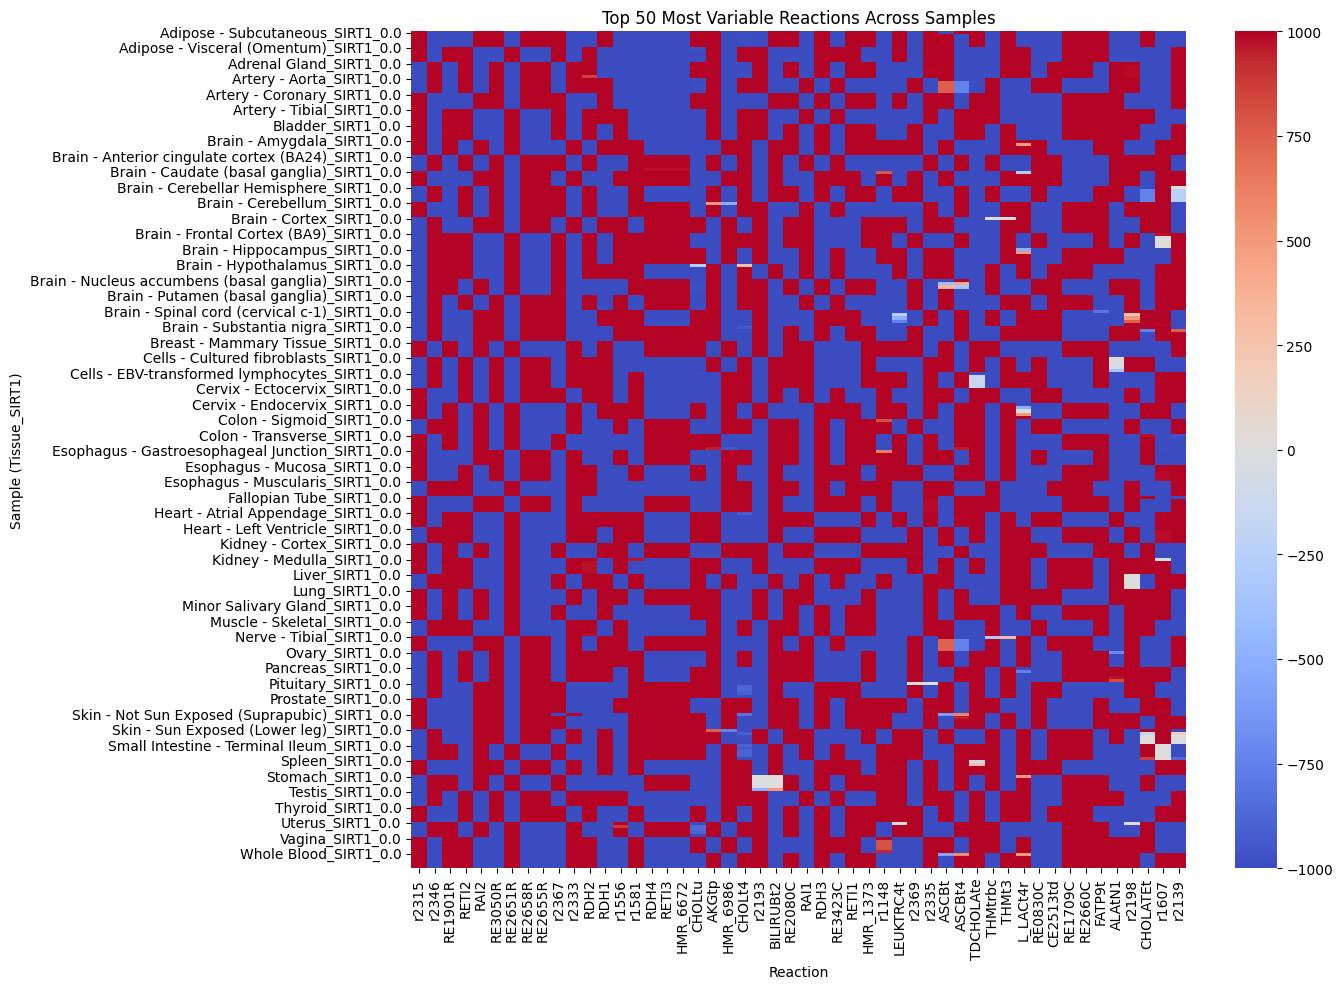

In [116]:
import seaborn as sns
import numpy as np

# Find top N most variable reactions
reaction_variance = flux_matrix_clean.var().sort_values(ascending=False)
top_reactions = reaction_variance.head(50).index

# Create heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(flux_matrix_clean[top_reactions], cmap='coolwarm', center=0)
plt.title('Top 50 Most Variable Reactions Across Samples')
plt.xlabel('Reaction')
plt.ylabel('Sample (Tissue_SIRT1)')
plt.tight_layout()
plt.show()


In [36]:
flux_matrix_clean = flux_matrix.fillna(0)

In [40]:
print(flux_matrix_clean.shape)
print(df_wide.shape)
print(flux_matrix_clean.index.equals(df_wide.index))  # Should be True

(270, 9709)
(270, 9710)
True


In [47]:
df_wide_cleaned["SIRT1"]

Sample
Adipose - Subcutaneous_SIRT1_0.0    NaN
Adipose - Subcutaneous_SIRT1_0.25   NaN
Adipose - Subcutaneous_SIRT1_0.5    NaN
Adipose - Subcutaneous_SIRT1_0.75   NaN
Adipose - Subcutaneous_SIRT1_1.0    NaN
                                     ..
Whole Blood_SIRT1_0.0               NaN
Whole Blood_SIRT1_0.25              NaN
Whole Blood_SIRT1_0.5               NaN
Whole Blood_SIRT1_0.75              NaN
Whole Blood_SIRT1_1.0               NaN
Name: SIRT1, Length: 270, dtype: float64

In [70]:
df_wide_cleaned.index = df_wide_cleaned.index.astype(str)

# Now extract works when assigning
df_wide_cleaned['SIRT1'] = df_wide_cleaned.index.to_series().str.extract(r'_SIRT1_(\d+\.\d+)$')[0].astype(float)

In [71]:
print(df_wide_cleaned['SIRT1'].unique())

[0.   0.25 0.5  0.75 1.  ]


In [72]:
df_wide_cleaned['SIRT1']

Sample
Adipose - Subcutaneous_SIRT1_0.0     0.00
Adipose - Subcutaneous_SIRT1_0.25    0.25
Adipose - Subcutaneous_SIRT1_0.5     0.50
Adipose - Subcutaneous_SIRT1_0.75    0.75
Adipose - Subcutaneous_SIRT1_1.0     1.00
                                     ... 
Whole Blood_SIRT1_0.0                0.00
Whole Blood_SIRT1_0.25               0.25
Whole Blood_SIRT1_0.5                0.50
Whole Blood_SIRT1_0.75               0.75
Whole Blood_SIRT1_1.0                1.00
Name: SIRT1, Length: 270, dtype: float64

In [73]:
pca_df = pd.DataFrame(reduced, columns=['PC1', 'PC2'])
pca_df['SIRT1'] = df_wide_cleaned['SIRT1'].values

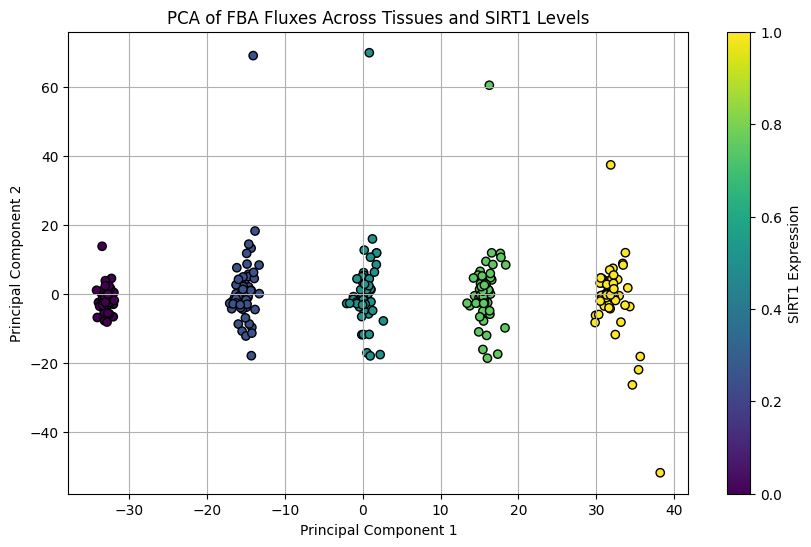

In [74]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    pca_df['PC1'],
    pca_df['PC2'],
    c=pca_df['SIRT1'],
    cmap='viridis',
    edgecolor='k'
)
plt.colorbar(scatter, label='SIRT1 Expression')
plt.title('PCA of FBA Fluxes Across Tissues and SIRT1 Levels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


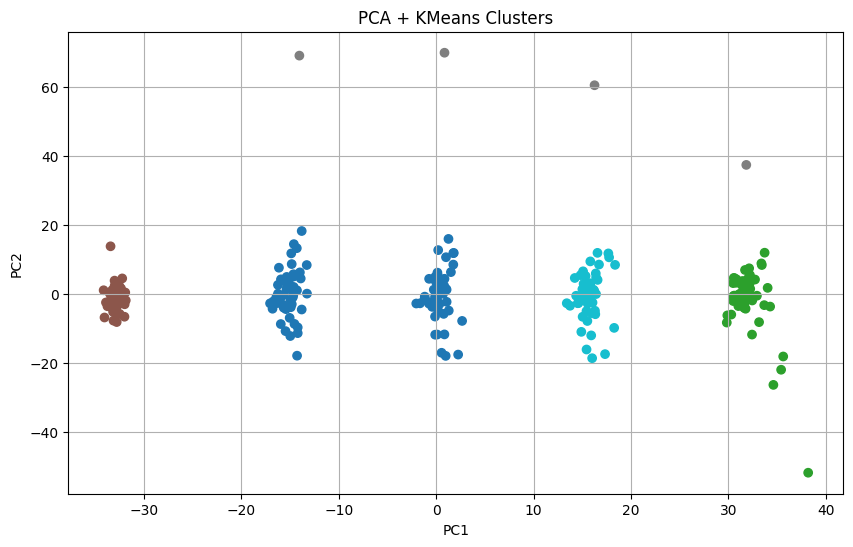

In [65]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(reduced)

plt.figure(figsize=(10, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], c=clusters, cmap='tab10')
plt.title("PCA + KMeans Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


In [27]:
flux_matrix_scaled 

array([[-0.10648211, -0.10648211,  0.10648211, ...,  0.84491918,
         0.82951447, -1.23098282],
       [-0.10648211, -0.10648211,  0.10648211, ...,  0.84491918,
        -0.01001123, -1.23098282],
       [-0.10648211, -0.10648211,  0.10648211, ...,  0.84491918,
        -0.84953692, -1.23098282],
       ...,
       [-0.10648211, -0.10648211,  0.10648211, ...,  0.84491918,
        -0.71668435,  0.84376978],
       [-0.10648211, -0.10648211,  0.10648211, ...,  0.84491918,
        -1.66645926,  0.84376978],
       [-0.10648211, -0.10648211,  0.10648211, ...,  0.84491918,
        -2.52019306,  0.84376978]])

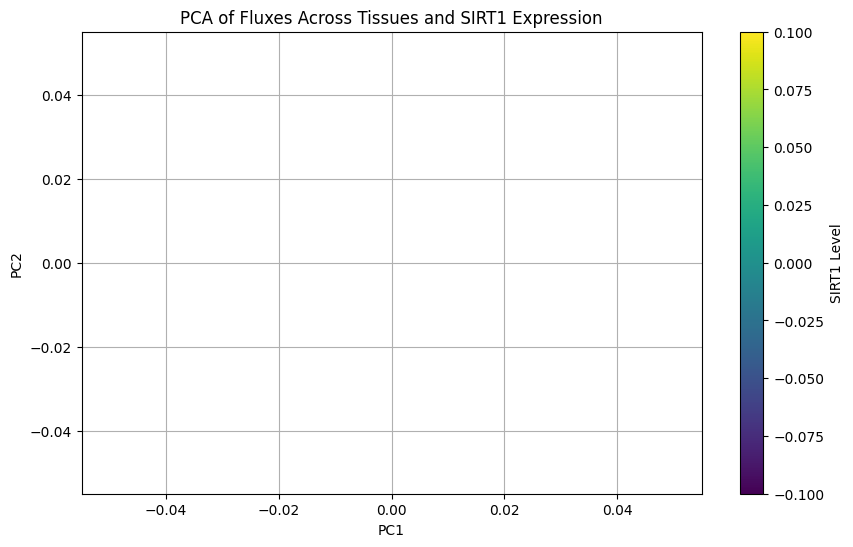

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    reduced[:, 0],
    reduced[:, 1],
    c=df_wide['SIRT1'],
    cmap='viridis'
)
plt.colorbar(scatter, label='SIRT1 Level')
plt.title('PCA of Fluxes Across Tissues and SIRT1 Expression')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()


In [29]:
print(reduced.shape)
print(pd.DataFrame(reduced).describe())


(270, 2)
                  0             1
count  2.700000e+02  2.700000e+02
mean   5.000116e-16 -7.368591e-16
std    2.283164e+01  1.026919e+01
min   -3.418404e+01 -4.987786e+01
25%   -1.597414e+01 -3.376863e+00
50%    2.214916e-01 -1.011742e+00
75%    1.626140e+01  2.886940e+00
max    3.821503e+01  7.189933e+01


In [30]:
print(df_wide['SIRT1'].unique())

[nan]


In [32]:
print(flux_matrix_scaled.std(axis=0).mean())  # Should not be ~0


nan


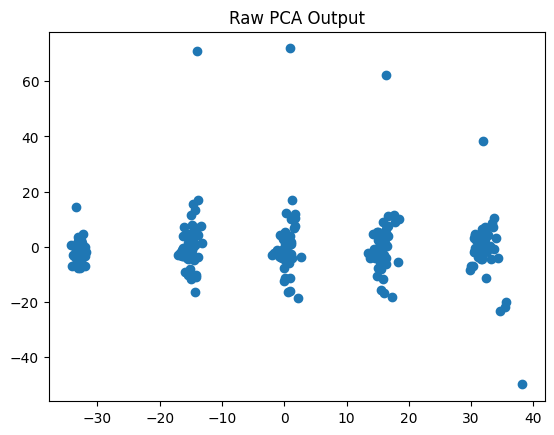

In [33]:
plt.scatter(reduced[:, 0], reduced[:, 1])
plt.title("Raw PCA Output")
plt.show()

In [133]:
# Compute variance per reaction
reaction_variance = flux_matrix_clean.var(axis=0)

# Select top N most variable reactions
top_n = 200
top_reactions = reaction_variance.sort_values(ascending=False).head(top_n).index

# Filter the flux matrix
flux_matrix_top = flux_matrix_clean[top_reactions]


In [134]:
# Standardize again
flux_scaled_top = scaler.fit_transform(flux_matrix_top)

# PCA on top-variable reactions
pca = PCA(n_components=2)
reduced_top = pca.fit_transform(flux_scaled_top)

# Build plotting dataframe again
pca_top_df = pd.DataFrame(reduced_top, columns=['PC1', 'PC2'], index=df_wide.index)
pca_top_df['Tissue'] = df_wide['Tissue']
pca_top_df['SIRT1'] = df_wide['SIRT1']


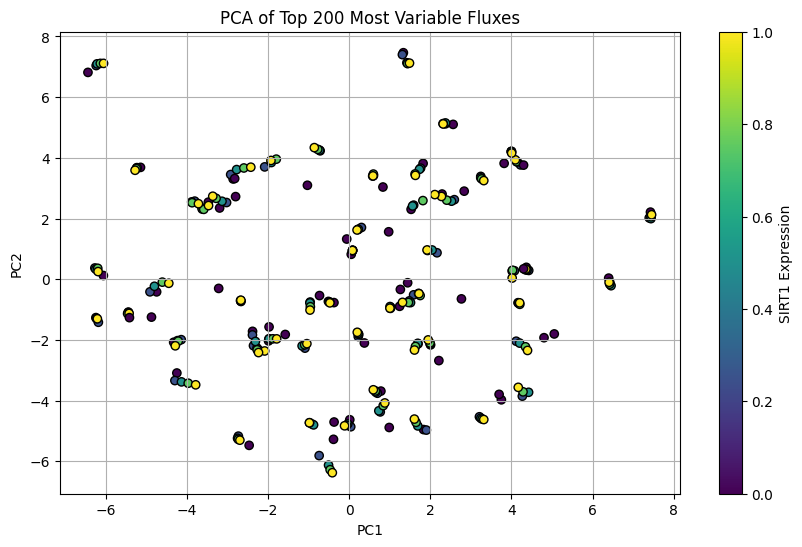

In [135]:
plt.figure(figsize=(10, 6))
plt.scatter(pca_top_df['PC1'], pca_top_df['PC2'], c=pca_top_df['SIRT1'], cmap='viridis', edgecolor='k')
plt.colorbar(label='SIRT1 Expression')
plt.title(f'PCA of Top {top_n} Most Variable Fluxes')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()


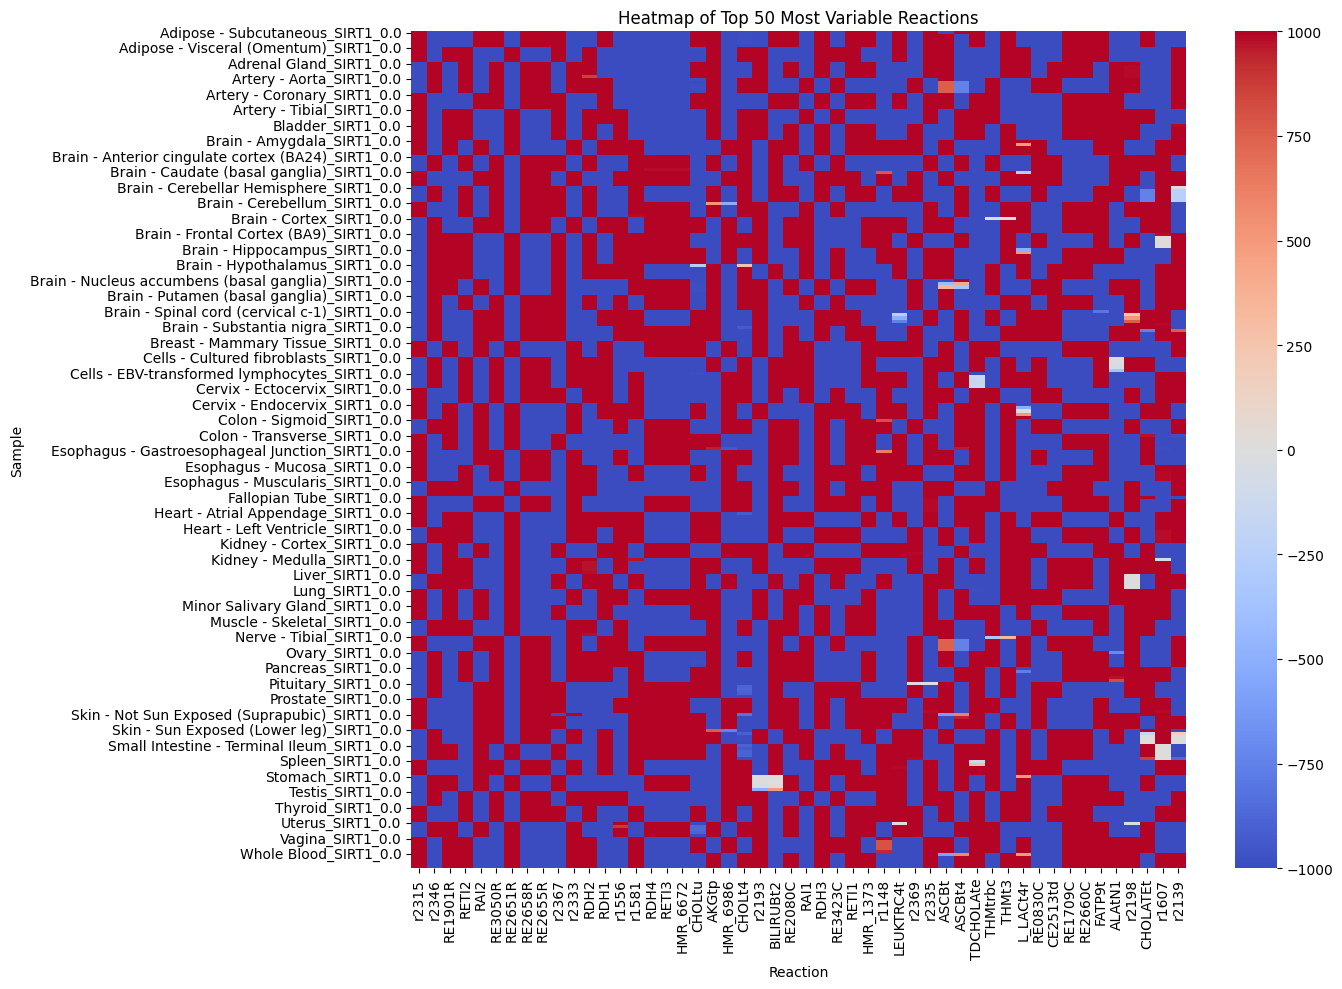

In [132]:
plt.figure(figsize=(14, 10))
sns.heatmap(flux_matrix_top, cmap='coolwarm', center=0)
plt.title(f'Heatmap of Top {top_n} Most Variable Reactions')
plt.xlabel('Reaction')
plt.ylabel('Sample')
plt.tight_layout()
plt.show()


C:\Users\Jordi\miniconda3\envs\cobrapy\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


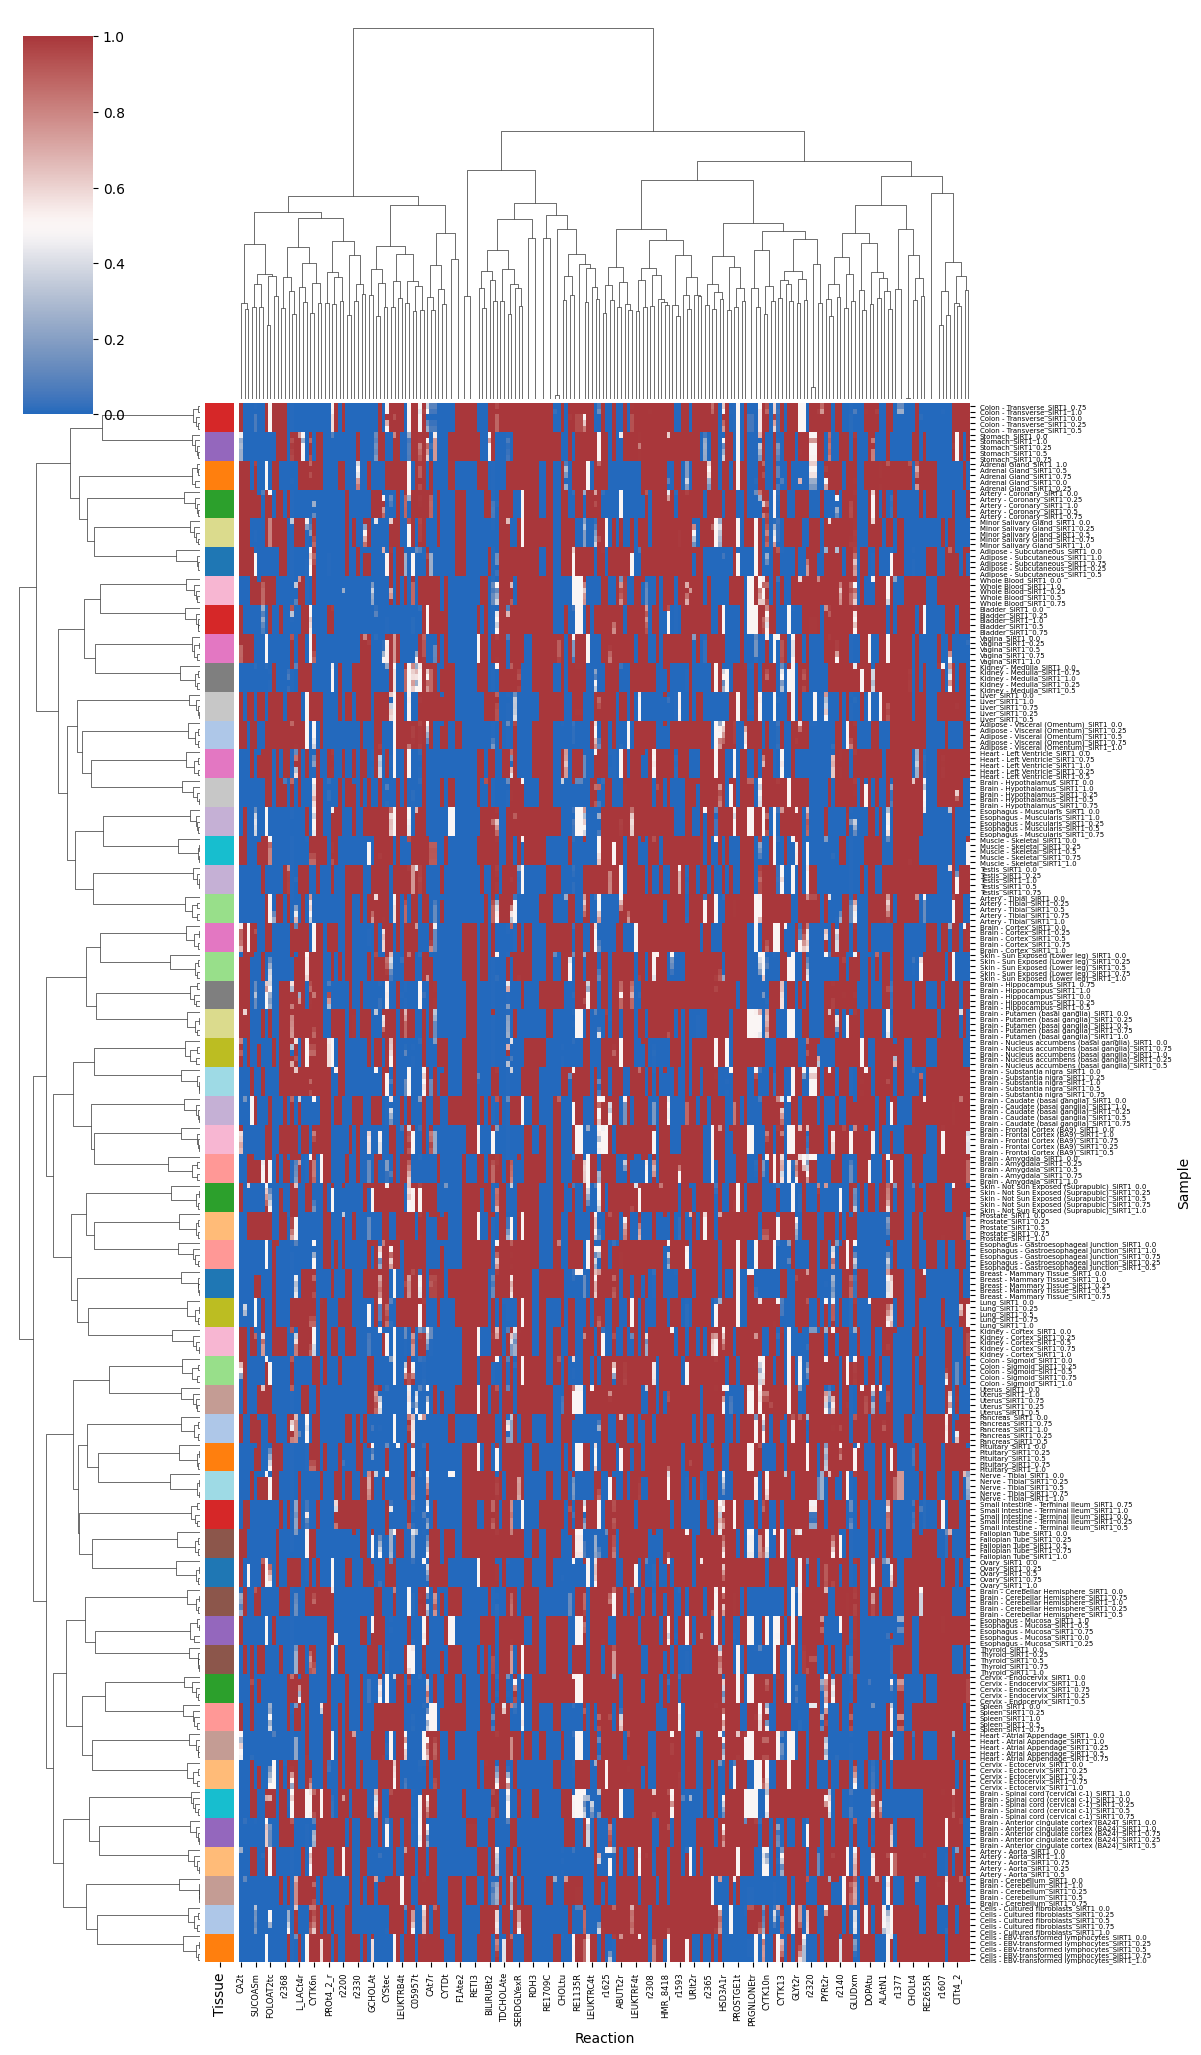

In [144]:
# Map tissue → color
import seaborn as sns
unique_tissues = df_wide['Tissue'].unique()
palette = sns.color_palette("tab20", len(unique_tissues))
tissue_colors = dict(zip(unique_tissues, palette))
row_colors = df_wide['Tissue'].map(tissue_colors)
cg = sns.clustermap(
    flux_matrix_top,
    row_colors=row_colors,
    cmap='vlag',
    figsize=(14, 21),  # More balanced height
    method='ward',
    metric='euclidean',
    standard_scale=1,
    yticklabels=row_labels
)

# Set label font size
cg.ax_heatmap.set_yticklabels(cg.ax_heatmap.get_yticklabels(), fontsize=5)
cg.ax_heatmap.set_xticklabels(cg.ax_heatmap.get_xticklabels(), fontsize=6)

cg.savefig("top200_clustermap_clean.png", dpi=300)

In [ ]:
# Map tissue → color
import seaborn as sns
unique_tissues = df_wide['Tissue'].unique()
palette = sns.color_palette("tab20", len(unique_tissues))
tissue_colors = dict(zip(unique_tissues, palette))
row_colors = df_wide['Tissue'].map(tissue_colors)

# Rerun with row colors
cg = sns.clustermap(
    flux_matrix_top,
    row_colors=row_colors,
    cmap='vlag',
    figsize=(14, 12),
    method='ward',
    metric='euclidean',
    standard_scale=1,
    yticklabels=row_labels
)
cg.savefig("top200_clustermap_colored.png", dpi=300)
